In [12]:
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer

from tensorflow.keras.utils import plot_model

from utils import *

# for Robust location estimation
from statsmodels import robust
import statsmodels.api as sm
from astropy.stats import biweight_location

tf.random.set_seed(25)

In [4]:
returns = pd.read_pickle("data/stocks_returns.pkl")

In [5]:
returns

VOW3 GY Equity  ENGI FP Equity  BAYN GY Equity  BNP FP Equity  \
2014-01-03        0.000000        0.001793        0.007468       0.002518   
2014-01-06       -0.008766       -0.012016       -0.004474       0.001615   
2014-01-07        0.006270        0.012314        0.010409       0.028285   
2014-01-08        0.000750        0.005952       -0.012903       0.014192   
2014-01-09       -0.003503       -0.007745       -0.012870      -0.016810   
...                    ...             ...             ...            ...   
2018-12-21       -0.004178        0.003604        0.006373       0.002535   
2018-12-24        0.000000       -0.018556        0.000000      -0.018138   
2018-12-27       -0.041753       -0.021400       -0.037001      -0.006336   
2018-12-28        0.010711        0.020993        0.023389       0.021305   
2018-12-31        0.000000        0.020162        0.000000       0.002536   

            PHIA NA Equity  ISP IM Equity  SAN FP Equity  MC FP Equity  \
2014-01-03        0.004657       0.014477       0.013731     -0.001907   
2014-01-06        0.007775       0.010448       0.001310     -0.018879   
2014-01-07        0.007898       0.032296      -0.001179     -0.007026   
2014-01-08        0.001828       0.021484      -0.012401     -0.014599   
2014-01-09       -0.005126       0.007746      -0.011885     -0.022916   
...                    ...            ...            ...           ...   
2018-12-21       -0.002109      -0.017008      -0.006191      0.013306   
2018-12-24       -0.013570       0.000000      -0.019211     -0.033296   
2018-12-27       -0.002307      -0.001675      -0.006486      0.008125   
2018-12-28        0.012787       0.016005       0.019601      0.022405   
2018-12-31        0.007627       0.000000       0.005832      0.021334   

            ENEL IM Equity  CS FP Equity  ...  GLE FP Equity  ITX SQ Equity  \
2014-01-03        0.013942      0.003797  ...      -0.004708       0.002526   
2014-01-06        0.002514     -0.002023  ...       0.009273      -0.005059   
2014-01-07        0.012477      0.025001  ...       0.039488       0.009674   
2014-01-08        0.004947      0.006890  ...       0.029297      -0.006720   
2014-01-09       -0.006809     -0.010353  ...      -0.002465      -0.002532   
...                    ...           ...  ...            ...            ...   
2018-12-21        0.007354      0.005762  ...       0.005712       0.003964   
2018-12-24        0.000000     -0.001491  ...      -0.017236      -0.022223   
2018-12-27       -0.026971     -0.012223  ...      -0.014410      -0.002700   
2018-12-28       -0.000793      0.012862  ...       0.021088       0.008973   
2018-12-31        0.000000      0.004145  ...       0.000899      -0.001788   

            OR FP Equity  BBVA SQ Equity  ASML NA Equity  SAP GY Equity  \
2014-01-03      0.007535       -0.003204       -0.000148       0.000648   
2014-01-06     -0.009129        0.010603       -0.025412       0.004688   
2014-01-07      0.005567        0.055475       -0.008057      -0.007935   
2014-01-08     -0.018812        0.006949        0.002743       0.016766   
2014-01-09     -0.013014       -0.009635        0.010297      -0.012872   
...                  ...             ...             ...            ...   
2018-12-21     -0.004474       -0.007657       -0.013445      -0.015501   
2018-12-24     -0.015313       -0.013186       -0.015918       0.000000   
2018-12-27     -0.010426       -0.002856        0.013207      -0.007317   
2018-12-28      0.012700        0.020902        0.029715       0.013201   
2018-12-31      0.015527       -0.001186        0.003945       0.000000   

            INGA NA Equity  ENI IM Equity  ABI BB Equity  DTE GY Equity  
2014-01-03        0.000496       0.009195       0.011179       0.011476  
2014-01-06       -0.010366       0.005705      -0.018080      -0.006541  
2014-01-07        0.034853       0.004540       0.019910       0.004910  
2014-01-08        0.021064      -0.016558       0.00

In [13]:
(1 + returns).prod() - 1

VOW3 GY Equity   -0.475470
ENGI FP Equity   -0.344144
BAYN GY Equity   -0.480415
BNP FP Equity    -0.413272
PHIA NA Equity    0.022332
ISP IM Equity    -0.217251
SAN FP Equity    -0.107312
MC FP Equity      0.880094
ENEL IM Equity    0.375638
CS FP Equity     -0.197621
VIV FP Equity     0.058414
SU FP Equity     -0.175749
MUV2 GY Equity    0.121090
DPW GY Equity    -0.186336
AIR FP Equity     0.229500
EL FP Equity      0.286073
BAS GY Equity    -0.300240
ORA FP Equity     0.403918
TEF SQ Equity    -0.447780
null             -0.081027
SIE GY Equity    -0.124166
AI FP Equity      0.208218
null.1           -0.358892
BN FP Equity      0.096316
SAN SQ Equity    -0.501804
DG FP Equity      0.363147
BMW GY Equity    -0.273576
null.2            0.452636
ALV GY Equity     0.227393
IBE SQ Equity     0.406535
GLE FP Equity    -0.480808
ITX SQ Equity    -0.172474
OR FP Equity      0.454791
BBVA SQ Equity   -0.569540
ASML NA Equity    0.680305
SAP GY Equity     0.272014
INGA NA Equity   -0.231157
E

In [15]:
X = returns

In [29]:
def cum_returns_from_series(series):
    result = [1]
    for i in range(len(series)):
        x = result[-1] * (1 + series.iloc[i])
        result.append(x)
    return np.array(result[1:])

In [40]:
lista = pd.Series([0.1, 0.2, -0.1, 0.3])

In [41]:
cum_returns_from_series(lista)

array([1.1   , 1.32  , 1.188 , 1.5444])

In [42]:
X.iloc[:, 0].shape

(1271,)

In [43]:
cum_returns_from_series(X.iloc[:, 0])

array([1.        , 0.99123354, 0.99744814, ..., 0.51897095, 0.52452952,
       0.52452952])

In [45]:
cum_ret_df = pd.DataFrame({column: cum_returns_from_series(X[column]) for column in X.columns})

<Axes: >

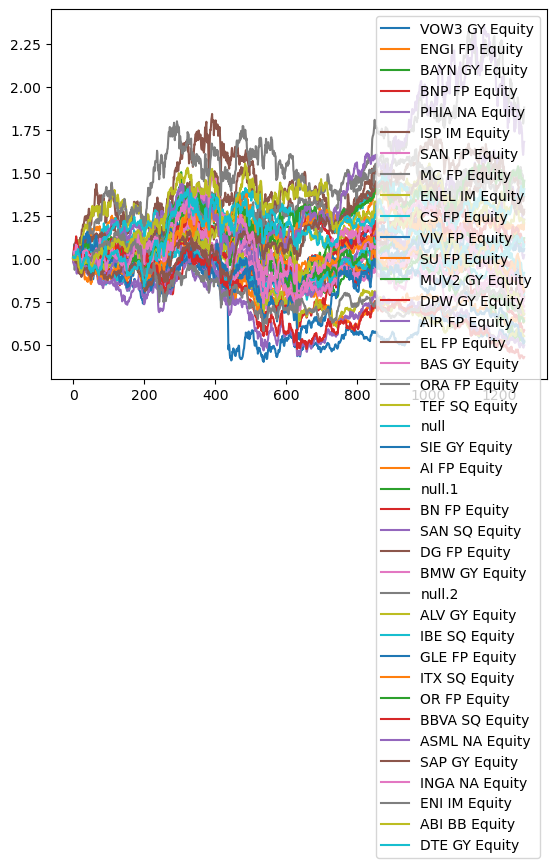

In [46]:
cum_ret_df.plot()